In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn, Tensor, optim

import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simple neural network and training and validation
This notebook <mark>extends part 06 to include evaluation of the DNN on unseen data during training.</mark>

### Data generation

In [3]:
n = 200
r = np.linspace(0.1,5, n)+np.random.normal(scale=0.3, size=n)
t = np.linspace(-np.pi, np.pi, n)
x0 = np.array(list(zip(r*np.cos(t), r*np.sin(t), np.ones_like(t))))
t = np.linspace(0, 2*np.pi, n)
x1 = np.array(list(zip(r*np.cos(t), r*np.sin(t), np.zeros_like(t))))

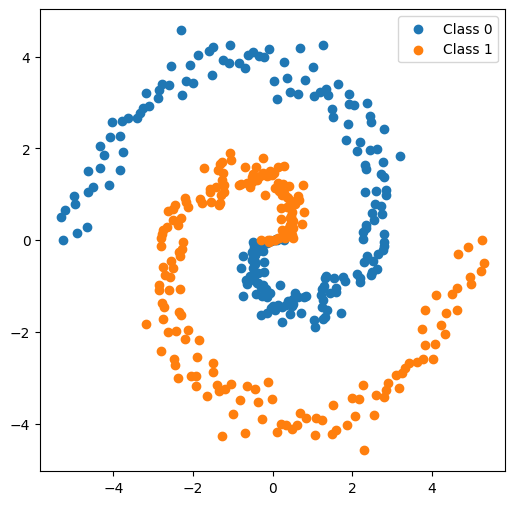

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(x0[:,0], x0[:,1], label='Class 0')
plt.scatter(x1[:,0], x1[:,1], label='Class 1')
plt.legend()

So we have points of two classes, indicated by their colour, which exist in 2D, and follow an obvious pattern, which the DNN should be able learn.

In [5]:
data = np.vstack((x0, x1))
np.random.shuffle(data)
x = Tensor(data[:,0:2])
y = Tensor(data[:,2:3])

x[:10], y[:10]

(tensor([[ 0.2405, -1.7816],
         [-2.3244, -1.0555],
         [-2.3727,  0.3394],
         [ 1.8899,  2.5417],
         [ 3.2492, -2.8856],
         [ 3.7896, -2.5921],
         [ 2.8119,  2.4189],
         [-2.2673,  3.1520],
         [-0.6687, -0.8702],
         [ 0.7000,  4.1842]]),
 tensor([[1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.]]))

x are our inputs for the network - the position of the points in 2D space

y are the target for the network - the classes for the corresponding points

### DNN
Now we need a suitable DNN for fit to the data

In [6]:
class DNN(nn.Module):
    def __init__(self, sizes):
        super().__init__()
        self.layers = nn.Sequential(*[self.get_layer(sizes[i], sizes[i+1]) for i in range(len(sizes)-2)])
        self.out_layer = self.get_layer(sizes[-2], sizes[-1], out_layer=True)

    @staticmethod
    def get_layer(nin, nout, out_layer=False):
        lin = nn.Linear(nin, nout)
        if out_layer:
            nn.init.xavier_normal_(lin.weight)
            act = nn.Sigmoid()
        else:
            nn.init.kaiming_normal_(lin.weight, nonlinearity='relu')
            act = nn.ReLU()
        nn.init.zeros_(lin.bias)
        
        return nn.Sequential(lin, act)
    
    def forward(self, x):
        x = self.layers(x)
        return self.out_layer(x)

In [7]:
dnn = DNN([2,10,10,1])
dnn

DNN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (out_layer): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

### Loss function
For this, we can just use binary cross entropy

In [8]:
loss_fn = nn.BCELoss()

### Optimsier
This time, we'll use ([paper](https://arxiv.org/abs/1412.6980), [blog](https://ruder.io/optimizing-gradient-descent/index.html#adam)), which is more advanced optimiser 

In [9]:
opt = optim.Adam(dnn.parameters(), lr=2e-2)

## Training loop
During training, the DNN <mark>sees the same data multiple times, and it is possible that it can "over-fit" to this data, by picking up on *noise* in that is not representative of the general data.</mark> We can attempt to <mark>spot this by retaining a "validation" dataset, which is never used to update parameters, only to monitor general performance.</mark> We will extend our training loop from last time, and make it <mark>evaluate the loss on the validation data after every epoch.</mark>

In order to prevent over training, <mark>we will save a copy of the DNN parameters every time the validation loss improves. At the end of training, we will reload the best performing parameters.</mark>

In [10]:
normed_x = (x-x.mean(dim=0))/x.std(0)  # Normalise the inputs per feature

In [11]:
import math

def train_with_val(dnn, *, inputs, targets, inputs_val, targets_val,
                   batch_size, loss_fn, opt, nepochs):
    trn_losses, val_losses = [],[]
    best_val_loss = math.inf
    
    for epoch in range(1,nepochs+1):
        idxs = torch.randperm(len(inputs)) # shuffle indicies of the data (rather than the data itself)
        epoch_losses = []
        
        # Our training epoch remains the same
        for batch in range(0, len(inputs)-batch_size, batch_size):  # Loop through minibatches of data
            batch_idxs = idxs[batch : batch_size+batch]
            pred = dnn(inputs[batch_idxs])  # Forwards pass
            loss = loss_fn(pred, targets[batch_idxs])
            epoch_losses.append(loss.item())
            opt.zero_grad()  # Make sure the grads are zero
            loss.backward()  # Backwards pass and update
            opt.step()
            
        # After a complete training epoch, we evaluate the DNN using the validation data
        with torch.inference_mode():
            val_preds = dnn(inputs_val)
            val_loss = loss_fn(val_preds, targets_val)
        
        if best_val_loss > val_loss:  # If the loss improves, save the DNN
            torch.save(dnn.state_dict(), 'tmp.pt')
            best_val_loss = val_loss
        
        trn_losses.append(np.mean(epoch_losses))
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch}: training loss = {trn_losses[-1]:.2E}, val_loss = {val_loss:.2E}')
    
    print(f"Reloading the best DNN, with val_loss {best_val_loss}")
    dnn.load_state_dict(torch.load('tmp.pt'))
    return trn_losses, val_losses

To simulate our validation data, we will take the last 100 points, and slightly perturb them.<mark>Normally, this perturbation wouldn't be done, we are simply ensuring that our validation dataset is slightly different to the training dataset.</mark>

In [12]:
trn_x = normed_x[:300]
val_x = normed_x[300:]

In [13]:
trn_y = y[:300]
val_y = y[300:]

In [14]:
val_x += torch.rand_like(val_x)*0.1

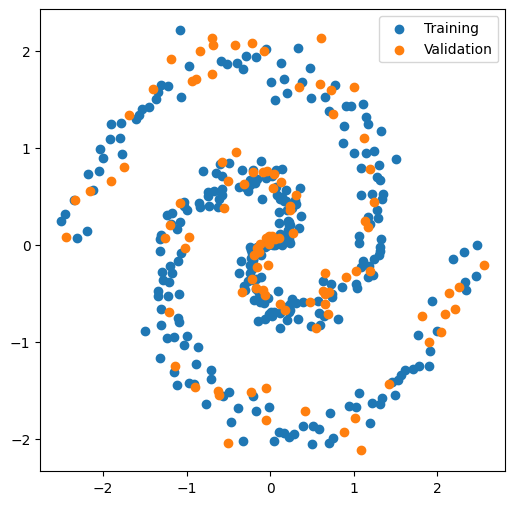

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(trn_x[:,0], trn_x[:,1], label='Training')
plt.scatter(val_x[:,0], val_x[:,1], label='Validation')
plt.legend()

Now we train the DNN for a very long time

In [16]:
losses = train_with_val(dnn, inputs=trn_x, targets=trn_y,
               inputs_val=val_x, targets_val=val_y, 
               batch_size=32, loss_fn=loss_fn, opt=opt, nepochs=500)

Epoch 1: training loss = 6.44E-01, val_loss = 6.06E-01
Epoch 2: training loss = 5.68E-01, val_loss = 5.45E-01
Epoch 3: training loss = 5.30E-01, val_loss = 4.88E-01
Epoch 4: training loss = 4.68E-01, val_loss = 4.27E-01
Epoch 5: training loss = 4.02E-01, val_loss = 3.41E-01
Epoch 6: training loss = 3.16E-01, val_loss = 2.59E-01
Epoch 7: training loss = 2.46E-01, val_loss = 2.00E-01
Epoch 8: training loss = 1.84E-01, val_loss = 1.59E-01
Epoch 9: training loss = 1.40E-01, val_loss = 1.21E-01
Epoch 10: training loss = 1.09E-01, val_loss = 9.90E-02
Epoch 11: training loss = 9.09E-02, val_loss = 8.41E-02
Epoch 12: training loss = 7.42E-02, val_loss = 8.78E-02
Epoch 13: training loss = 7.33E-02, val_loss = 6.72E-02
Epoch 14: training loss = 5.96E-02, val_loss = 6.53E-02
Epoch 15: training loss = 5.48E-02, val_loss = 6.27E-02
Epoch 16: training loss = 5.37E-02, val_loss = 5.90E-02
Epoch 17: training loss = 4.74E-02, val_loss = 5.54E-02
Epoch 18: training loss = 4.27E-02, val_loss = 5.34E-02
E

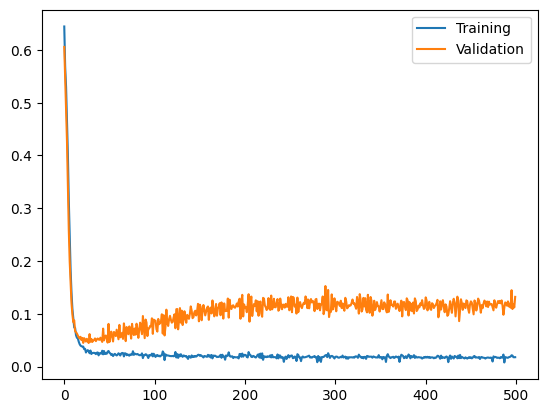

In [17]:
plt.plot(losses[0], label='Training')
plt.plot(losses[1], label='Validation')
plt.legend()

We see that eventually the validation loss begins to increase. <mark>The point where the validation loss is lowest, is the point at which we want to stop training, and it will also be the last point that the DNN parameters were saved.</mark>

We can check the validation performance:

In [18]:
with torch.inference_mode():
    preds = dnn(val_x)

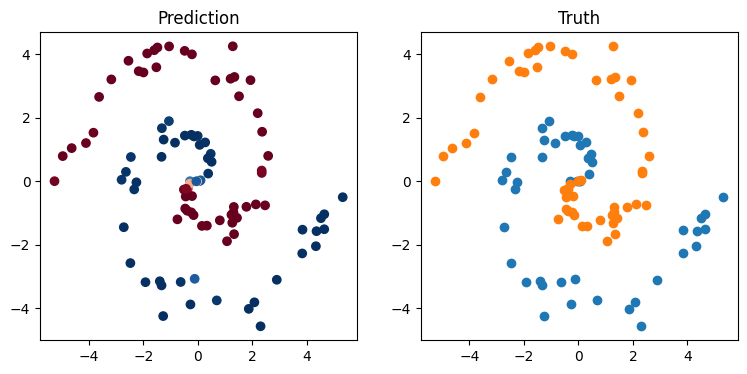

In [19]:
fig, axs = plt.subplots(1,2, figsize=(9,4))
axs[0].scatter(x[300:,0], x[300:,1], c=preds.squeeze(), cmap='RdBu_r')
axs[0].set_title('Prediction')
mask = y[300:].squeeze() == 1
axs[1].scatter(x[300:][~mask][:,0], x[300:][~mask][:,1])
axs[1].scatter(x[300:][mask][:,0], x[300:][mask][:,1])
axs[1].set_title('Truth');